# SunSpotter 
## Image classification with 3 classes sunny, cloudy, rainy

The procedure is based on the following tutorial from Tensorflow.org

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This code classifies images of webcams. It creates an image classifier using a `keras.Sequential` model, and loads data using `preprocessing.image_dataset_from_directory`. 

* Efficiently loading a dataset off disk.
* Identifying overfitting and applying techniques to mitigate it, including data augmentation and Dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
2. Build an input pipeline
3. Build the model
4. Train the model
5. Test the model
6. Improve the model and repeat the process

## Import TensorFlow and other libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Create callback instances
### Setup folder where to save logs for tensorboard, one folder for every run
### Create callback for ModelCheckpoint to save the model

In [75]:
#setup folder where to save logs for tensorflow
root_logdir = os.path.join(os.curdir,"my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [76]:
#create keras Tensorboard callback
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [78]:
#create keras ModelCheckpoint callback
checkpoint_cb = keras.callbacks.ModelCheckpoint("sunSpotter_keras_model.h5")

In [79]:
#create keras early stopping callback will be used later on
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
## Download and explore the dataset

We uses a dataset of about ??? photos of different landscapes from real webcams. The dataset contains 3 sub-directories, one per class:

```
/
  rainy/
  cloudy/
  sunny/  
```

In [1]:
import pathlib
data_dir = "..\..\data\images-classified"
data_dir = pathlib.Path(data_dir)
print(data_dir)

..\..\data\images-classified


You should now have a copy of the dataset available. There are ????? total images:

In [2]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1034


Here are some sunny pics:

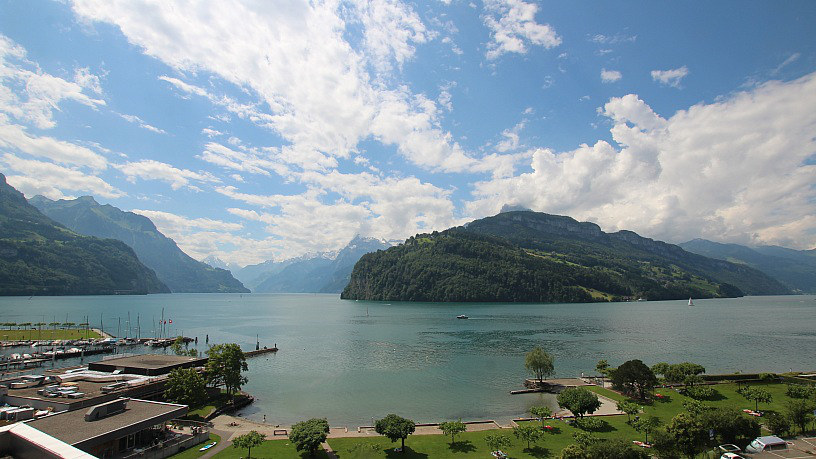

In [5]:
sunnyPics = list(data_dir.glob('sunny/*'))
PIL.Image.open(str(sunnyPics[0]))

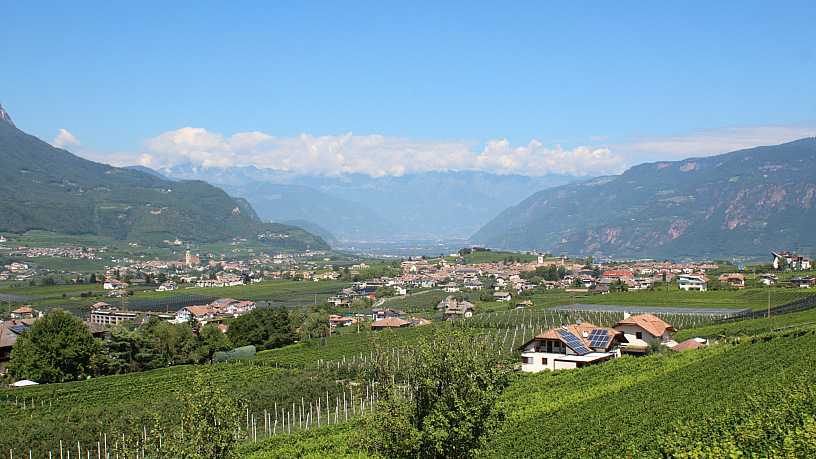

In [6]:
PIL.Image.open(str(sunnyPics[1]))

And some cloudy pics:

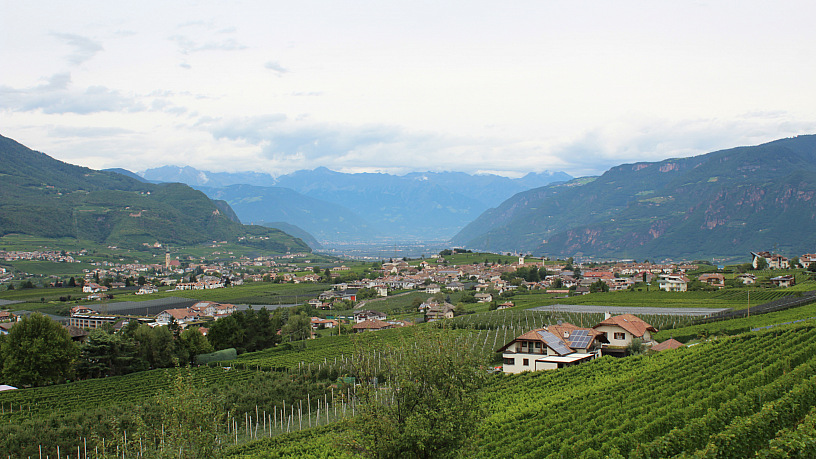

In [7]:
cloudyPics = list(data_dir.glob('cloudy/*'))
PIL.Image.open(str(cloudyPics[0]))

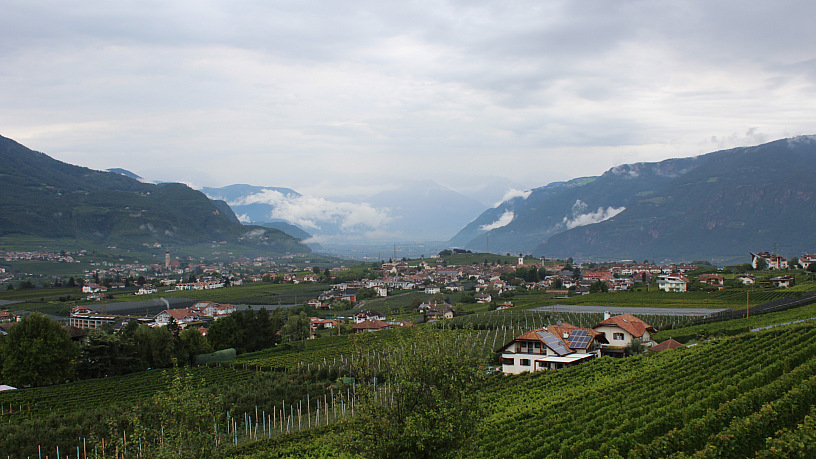

In [8]:
PIL.Image.open(str(cloudyPics[1]))

And some rainy pics:

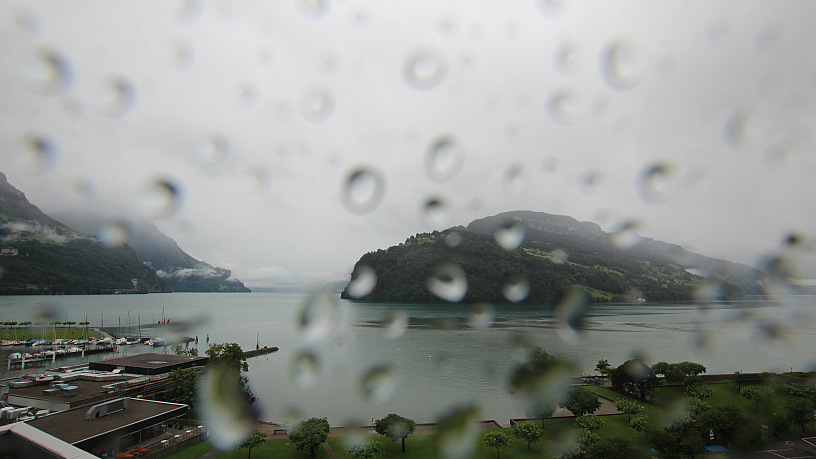

In [10]:
rainyPics = list(data_dir.glob('rainy/*'))
PIL.Image.open(str(rainyPics[0]))

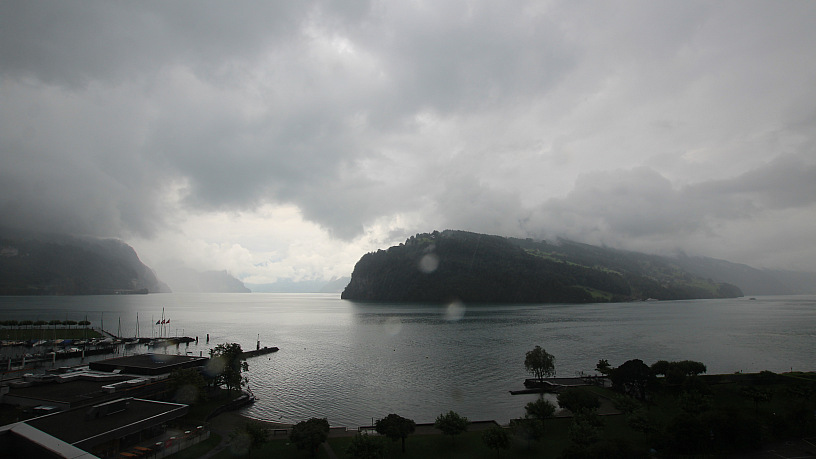

In [11]:
PIL.Image.open(str(rainyPics[1]))

# Load using keras.preprocessing

Load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will load the images from a directory on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

## Create a dataset

Define some parameters for the loader (parameters are used as suggested in tutorials):

In [35]:
batch_size = 32
img_height = 180
img_width = 180

Split the dataset in a validation an a training part which will be used by the model. Let's use 80% of the images for training, and 20% for validation.

In [36]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.
Using 828 files for training.


In [37]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1034 files belonging to 3 classes.
Using 206 files for validation.


The class names are listed in the `class_names` attribute on these dataset. These correspond to the directory names in alphabetical order.

In [38]:
class_names = train_ds.class_names
print(class_names)

['cloudy', 'rainy', 'sunny']


## Visualize the data

Here are the first 16 images from the training dataset.

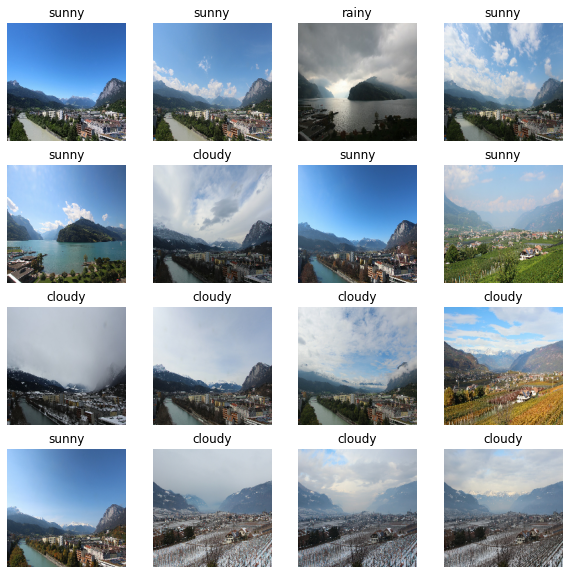

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Wil will train a model using these datasets by passing them to `model.fit` in a moment. Here we show that it is also possible to manually iterate over the dataset and retrieve batches of images:

In [40]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images. 

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. There are two important methods which should be used when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training the model. If the dataset is too large to fit into memory, this method can also be used to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [43]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general it is best do to make the input values small. Here, we will standardize values to be in the `[0, 1]` range by using a Rescaling layer.

In [44]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

There are two ways to use this layer. We can apply it to the dataset by calling map:

In [45]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0013395422 0.99380547


Or, we can include the layer inside our model definition, which can simplify deployment. Let's use the second approach here.

Note: we previously resized images using the `image_size` argument of `image_dataset_from_directory`. If we want to include the resizing logic in the model as well, we can use the [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) layer.

# Create the model

The first model consists of three convolution blocks with a max pool layer in each of them. There's a fully connected layer with 128 units on top of it that is activated by a `relu` activation function. Optimization will follow further down.


In [80]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Resizing(img_height, img_width, interpolation='bilinear'),
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer="he_normal"),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer="he_normal"),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer="he_normal"),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this model, wen choose the `optimizers.Adam` optimizer and `losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, we pass the `metrics` argument.

In [81]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `summary` method:

In [82]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

## Train the model

In [83]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks = [tensorboard_cb, checkpoint_cb]
)

Epoch 1/10
26/26 [==============================] - 18s 626ms/step - loss: 1.7339 - accuracy: 0.6087 - val_loss: 0.5796 - val_accuracy: 0.7816
Epoch 2/10
26/26 [==============================] - 15s 586ms/step - loss: 0.4561 - accuracy: 0.8200 - val_loss: 0.3717 - val_accuracy: 0.8447
Epoch 3/10
26/26 [==============================] - 15s 566ms/step - loss: 0.3095 - accuracy: 0.8647 - val_loss: 0.2913 - val_accuracy: 0.9029
Epoch 4/10
26/26 [==============================] - 14s 543ms/step - loss: 0.2808 - accuracy: 0.8901 - val_loss: 0.3473 - val_accuracy: 0.8447
Epoch 5/10
26/26 [==============================] - 17s 669ms/step - loss: 0.2743 - accuracy: 0.8804 - val_loss: 0.3184 - val_accuracy: 0.8689
Epoch 6/10
26/26 [==============================] - 21s 798ms/step - loss: 0.2244 - accuracy: 0.9082 - val_loss: 0.2753 - val_accuracy: 0.8981
Epoch 7/10
26/26 [==============================] - 23s 878ms/step - loss: 0.2088 - accuracy: 0.9046 - val_loss: 0.3191 - val_accuracy: 0.8641

## Visualize training results

Create plots of loss and accuracy on the training and validation sets.

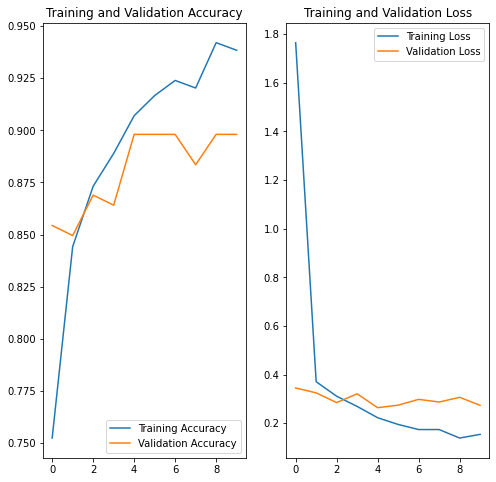

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by kind of a large margin but the model has achieved around 85% accuracy on the validation set.

Let's try out some optimizations to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 85% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. As a next step, we will use *data augmentation* and add *Dropout* to the model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

We will implement data augmentation using the layers from `tf.keras.layers.experimental.preprocessing`. These can be included inside the model like other layers, and run on the GPU.

In [63]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

Let's visualize what a few augmented examples look like by applying data augmentation to the same image several times:

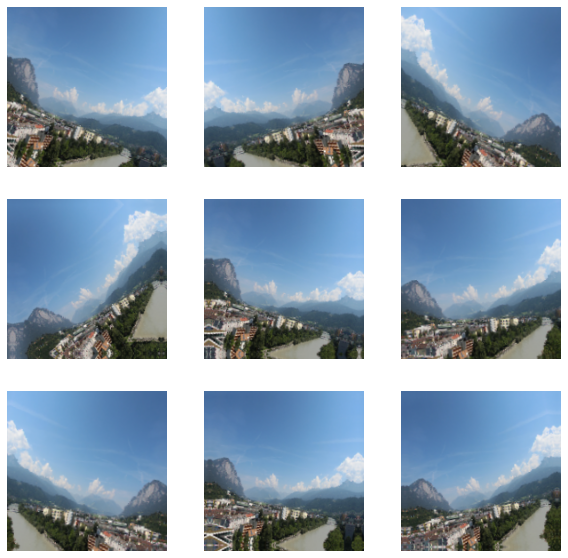

In [64]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

You will use data augmentation to train a model in a moment.

## Dropout

Another technique to reduce overfitting is to introduce [Dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) to the network, a form of *regularization*.

When we apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network using `layers.Dropout`, then train it using augmented images.

In [65]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Resizing(img_height, img_width, interpolation='bilinear'),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [67]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [68]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
resizing_3 (Resizing)        (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 45, 45, 32)       

In [69]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
26/26 [==============================] - 19s 680ms/step - loss: 0.7814 - accuracy: 0.6848 - val_loss: 0.5203 - val_accuracy: 0.8107
Epoch 2/15
26/26 [==============================] - 16s 620ms/step - loss: 0.4985 - accuracy: 0.8068 - val_loss: 0.4386 - val_accuracy: 0.8301
Epoch 3/15
26/26 [==============================] - 14s 549ms/step - loss: 0.4318 - accuracy: 0.8273 - val_loss: 0.3790 - val_accuracy: 0.8398
Epoch 4/15
26/26 [==============================] - 16s 630ms/step - loss: 0.3865 - accuracy: 0.8406 - val_loss: 0.3541 - val_accuracy: 0.8398
Epoch 5/15
26/26 [==============================] - 22s 851ms/step - loss: 0.4392 - accuracy: 0.8237 - val_loss: 0.4434 - val_accuracy: 0.8010
Epoch 6/15
26/26 [==============================] - 28s 1s/step - loss: 0.3682 - accuracy: 0.8466 - val_loss: 0.3634 - val_accuracy: 0.8301
Epoch 7/15
26/26 [==============================] - 29s 1s/step - loss: 0.3886 - accuracy: 0.8345 - val_loss: 0.3131 - val_accuracy: 0.8641
Epoch

## Visualize training results

After applying data augmentation and Dropout, it looks like ther is more overfitting than before, and training and validation accuracy are not at all closer aligned. We need no think about other optimizations.
Especially this spike between the 10th and 15th epoch in validation-accuracy and validation-loss is noticable.

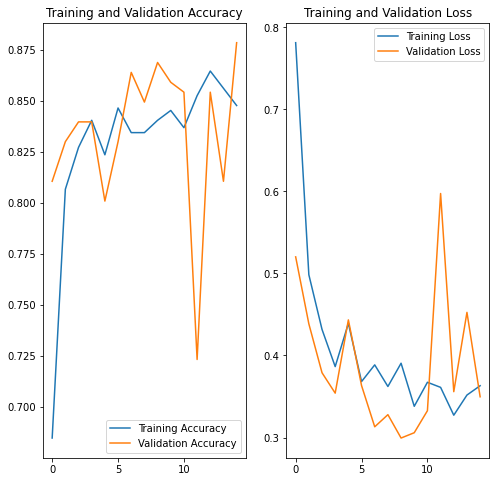

In [71]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and Dropout layers are inactive at inference time.

In [91]:
#https://www.foto-webcam.eu/webcam/tschagguns/2021/06/01/1140_hu.jpg
#https://www.foto-webcam.eu/webcam/tschagguns/2021/05/28/1510_hu.jpg
sunny_url = "https://www.foto-webcam.eu/webcam/tschagguns/2021/06/01/1140_hu.jpg"
sunny_path = tf.keras.utils.get_file('Tschagguns_SunnyWheater', origin=sunny_url)

img = keras.preprocessing.image.load_img(
    sunny_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to cloudy with a 60.34 percent confidence.


In [90]:

cloudy_url = "https://www.foto-webcam.eu/webcam/tschagguns/2021/05/27/1510_hu.jpg"
cloudy_path = tf.keras.utils.get_file('Tschagguns_CloudyWheater', origin=cloudy_url)

img = keras.preprocessing.image.load_img(
    cloudy_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to cloudy with a 60.34 percent confidence.


## considering exploding, vanishing problem (use antoher scaling function)

- Let's create a new neural network using kernel_initiliazier="he_normal" and add some mor layers
- Use early stopping callback

In [85]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Resizing(img_height, img_width, interpolation='bilinear'),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu', kernel_initializer="he_normal"),
  layers.Dense(64, activation='relu', kernel_initializer="he_normal"),
  layers.Dense(num_classes)
])

In [86]:
optimizer = keras.optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.99)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

C:\Users\maryl\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [87]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
resizing_6 (Resizing)        (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_9 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 45, 45, 32)       

In [88]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks = [tensorboard_cb, early_stopping_cb, checkpoint_cb]
)

Epoch 1/15
26/26 [==============================] - 23s 803ms/step - loss: 0.9528 - accuracy: 0.5109 - val_loss: 0.8150 - val_accuracy: 0.7573
Epoch 2/15
26/26 [==============================] - 18s 715ms/step - loss: 0.6745 - accuracy: 0.7609 - val_loss: 0.8233 - val_accuracy: 0.6893
Epoch 3/15
26/26 [==============================] - 18s 708ms/step - loss: 0.5447 - accuracy: 0.7923 - val_loss: 0.4516 - val_accuracy: 0.8155
Epoch 4/15
26/26 [==============================] - 23s 886ms/step - loss: 0.4678 - accuracy: 0.8188 - val_loss: 0.4251 - val_accuracy: 0.8155
Epoch 5/15
26/26 [==============================] - 29s 1s/step - loss: 0.4284 - accuracy: 0.8370 - val_loss: 0.4032 - val_accuracy: 0.8301
Epoch 6/15
26/26 [==============================] - 33s 1s/step - loss: 0.4528 - accuracy: 0.8140 - val_loss: 0.4311 - val_accuracy: 0.8155
Epoch 7/15
26/26 [==============================] - 32s 1s/step - loss: 0.3778 - accuracy: 0.8478 - val_loss: 0.3358 - val_accuracy: 0.8447
Epoch 8/

In [ ]:
## Visualize training results

After applying early stopping and kernel_initializer="he_normal", it looks like ther is less overfitting than before, and training and validation accuracy are closer aligned. There is still some potential to get a higher accuracy. wen need to try other optimizations

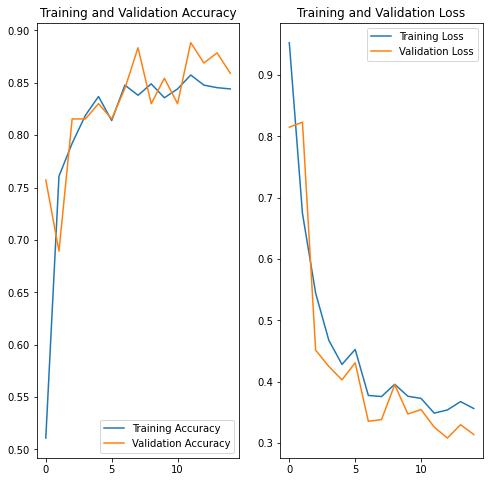

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir my_logs 

In [ ]:
#using the tf.summary API
test_logdir = get_run_logdir()
img = np.reshape(X_train[0:20], (-1, 28, 28, 1))
writer = tf.summary.create_file_writer(test_logdir)
with writer.as_default():
    tf.summary.image('my_images', img, step=0)

In [ ]:
# Testdaten müssen wir noch auftreiben und evaluieren
#model.evaluate(X_test, y_test)